# 1-D Linear Wave Example

Anthony Gruber 3-31-2023

In [1]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csc_matrix

import ROM_utils as ru
import OpInf_utils as ou
from KdV_BBM_utils import tridiag

# To suppress annoying umfpack "almost singular" warnings
import warnings
warnings.filterwarnings('ignore', '.*singular matrix!.*')

## Define functions for generating data

In [2]:
# Global parameter for Hamiltonian
c = 0.1


# Define hamiltonian (depends on c)
def Hamil(x, dx):
    q, p  = np.split(x, 2, axis=0)
    arr   = np.zeros_like(q)
    const = c**2 / (4*dx**2)

    # Recall periodic boundary conditions...
    arr[0]    = 0.5 * p[0]**2 + const * ( 
                (q[1]-q[0])**2 + (q[0]-q[-1])**2 )
    arr[1:-1] = 0.5 * p[1:-1]**2 + const * ( 
                (q[2:]-q[1:-1])**2 + (q[1:-1]-q[0:-2])**2 )
    arr[-1]   = 0.5 * p[-1]**2 + const * ( 
                (q[0]-q[-1])**2 + (q[-1]-q[-2])**2 )
    return np.sum(arr, axis=0)


# IC function
def s(x, a ,b): return a * np.abs(x - b)
def h(s): return np.where(s<=1, 1 - 3/2*s**2 + 3/4*s**3,
                          np.where(s<=2, 1/4*(2-s)**3, 0))
# def f(x): return 1 * np.exp(-(x-0.5)**2 / (2*0.02**2))


# Function to assemble FOM operators
def assemble_FOM(Nover2, xEnds):
    xRange = np.linspace(xEnds[0], xEnds[1], Nover2)
    dx     = xRange[1] - xRange[0]

    # Build L
    zz     = np.zeros((Nover2, Nover2))
    ii     = np.eye(Nover2)
    L      = np.block([[zz, ii], [-ii, zz]])

    # Build A s.t. gradH(x) = Ax
    qxx       = tridiag(np.ones(Nover2-1), -2*np.ones(Nover2),
                          np.ones(Nover2-1))
    qxx[-1,0] = 1
    qxx[0,-1] = 1
    qxx      *= (c/dx)**2
    A         = np.block([[-qxx, zz], [zz, ii]])

    return L, A

## Generating training/testing data

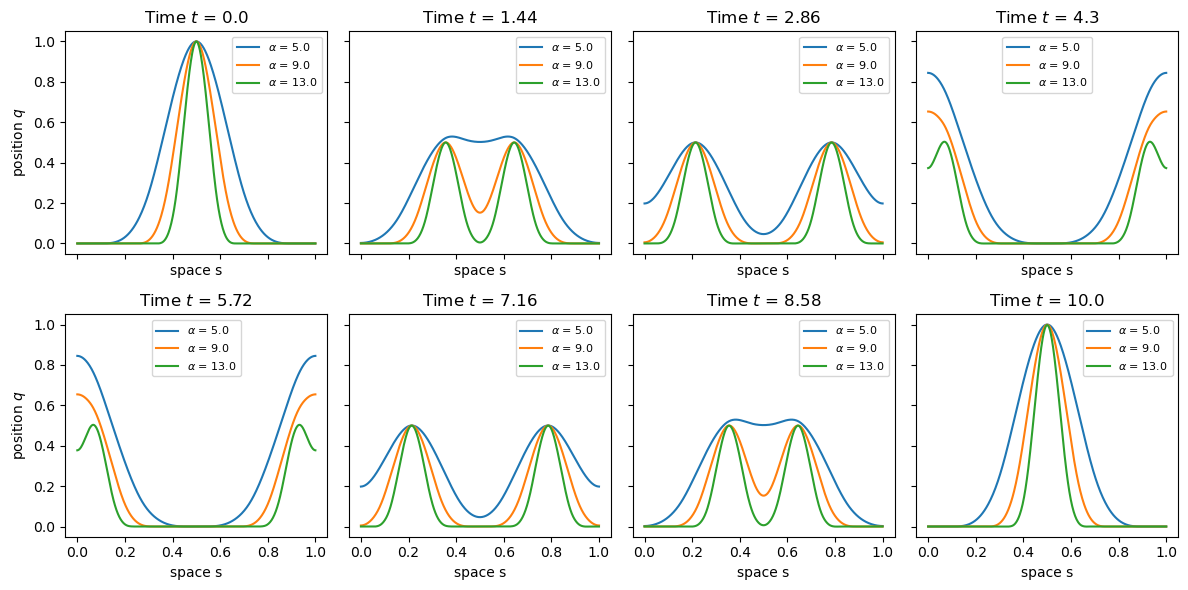

In [3]:
# Parameters for training
Nover2 = 500
Nt     = 501
T      = 10

# Ranges for training
xTrain = np.linspace(0, 1, Nover2)
tTrain = np.linspace(0, T, Nt)

# Generating ICs, 1-parameter family
npts = 11
aRange = np.linspace(5, 15, npts)
ICgrid = np.zeros((len(aRange), Nover2*2))

for i,a in enumerate(aRange):
    ICgrid[i] = np.concatenate((h(s(xTrain, a, 0.5)),
                                    np.zeros(Nover2)), axis=0)

# Assemble FOM and compute snapshots
L, A       = assemble_FOM(Nover2, [0,1])
X, Xd, gH  = ru.integrate_Linear_HFOM(tTrain, ICgrid[0], L, A)

# for mean centering
Xmc = X - ICgrid[0].reshape(-1,1)

for i,ic in enumerate(ICgrid[1:]):
    sol, soldot, grad = ru.integrate_Linear_HFOM(tTrain, ic, L, A)
    X  = np.concatenate((X,  sol),    axis=1)
    Xd = np.concatenate((Xd, soldot), axis=1)
    gH = np.concatenate((gH, grad),   axis=1)

    #for mean centering
    solmc = sol - ic.reshape(-1,1)
    Xmc   = np.concatenate((Xmc, solmc), axis=1)


name = "tab10"
cmap = plt.get_cmap(name)


fig, ax = plt.subplots(2, 4, figsize=(12,6), sharey=True, sharex=True)

ax.flatten()[0].set_ylabel(f'position $q$')
ax.flatten()[4].set_ylabel(f'position $q$')

# tList = [0, 50, 100, 150, 200, 250, 375, 500]
tList = [int(np.ceil(500/7*i)) for i in range(8)]
for k,t in enumerate(tList):
    ax.flatten()[k].plot(xTrain, X[:Nover2,t], label=r'$\alpha$ '+f'= {aRange[0]}', linestyle='-')
    ax.flatten()[k].plot(xTrain, X[:Nover2,t+1503], label=r'$\alpha$ '+f'= {aRange[4]}', linestyle='-')
    ax.flatten()[k].plot(xTrain, X[:Nover2,t+3507], label=r'$\alpha$ '+f'= {aRange[8]}', linestyle='-')

    ax.flatten()[k].set_title(f'Time $t$ = {t/50}')
    ax.flatten()[k].set_xlabel(f'space s')

    ax.flatten()[k].legend(prop={'size':8})
plt.tight_layout()
# plt.savefig(f'ParamWaveFOM', transparent=True)
plt.show()

## Nonparametric version

### Training the POD bases

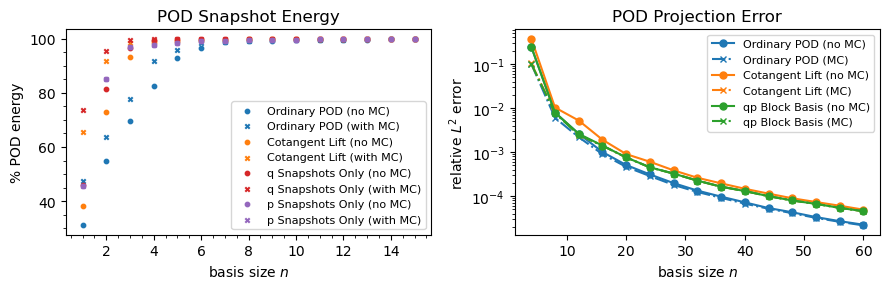

In [4]:
## Ordinary POD algo
UU, SS     = np.linalg.svd(X[:,:Nt])[:2]
UUmc, SSmc = np.linalg.svd(Xmc[:,:Nt])[:2]

### Cotangent lift algo:  U here is half the length of other one
Xlong        = np.concatenate((X[:Nover2,:Nt], X[Nover2:,:Nt]), axis=1)
Xmclong      = np.concatenate((Xmc[:Nover2,:Nt], Xmc[Nover2:,:Nt]), axis=1)
UU2, SS2     = np.linalg.svd(Xlong)[:2]
UU2mc, SS2mc = np.linalg.svd(Xmclong)[:2]

### Block q,p algo
UUq, SSq = np.linalg.svd(X[:Nover2,:Nt])[:2]
UUqmc, SSqmc = np.linalg.svd(Xmc[:Nover2,:Nt])[:2]
UUp, SSp = np.linalg.svd(X[Nover2:,:Nt])[:2]
UUpmc, SSpmc = np.linalg.svd(Xmc[Nover2:,:Nt])[:2]


nEigs = 15
idx = [i+1 for i in range(nEigs)]
X1 = X[:,:Nt]
ic = ICgrid[0].reshape(-1,1)

name = "tab10"
cmap = plt.get_cmap(name)

nList = [4*(i+1) for i in range(15)]
errU  = np.zeros(len(nList))
errUmc = np.zeros(len(nList))
errU2  = np.zeros(len(nList))
errU2mc = np.zeros(len(nList))
errUqp  = np.zeros(len(nList))
errUqpmc = np.zeros(len(nList))
for i,n in enumerate(nList):
    Umc   = UUmc[:,:n]
    U     = UU[:,:n]
    Ub    = UU2mc[:,:n//2]
    Zb    = np.zeros_like(Ub)
    U2mc = csc_matrix(np.block([[Ub, Zb], [Zb, Ub]]))
    Ub    = UU2[:,:n//2]
    Zb    = np.zeros_like(Ub)
    U2    = csc_matrix(np.block([[Ub, Zb], [Zb, Ub]]))
    Uq    = UUqmc[:,:n//2]
    Up    = UUpmc[:,:n//2]
    Zb    = np.zeros_like(Uq)
    Uqpmc = csc_matrix(np.block([[Uq, Zb], [Zb, Up]]))
    Uq    = UUq[:,:n//2]
    Up    = UUp[:,:n//2]
    Zb    = np.zeros_like(Uq)
    Uqp   = csc_matrix(np.block([[Uq, Zb], [Zb, Up]]))

    reconUmc   = ic.reshape(-1,1) + Umc @ Umc.T @ (X1 - ic.reshape(-1,1))
    reconU     = U @ U.T @ X1
    reconU2mc  = ic.reshape(-1,1) + U2mc @ U2mc.T @ (X1 - ic.reshape(-1,1))
    reconU2    = U2 @ U2.T @ X1
    reconUqpmc = ic.reshape(-1,1) + Uqpmc @ Uqpmc.T @ (X1 - ic.reshape(-1,1))
    reconUqp   = Uqp @ Uqp.T @ X1

    errUmc[i]   = ru.relError(X1, reconUmc)
    errU[i]     = ru.relError(X1, reconU)
    errU2mc[i]  = ru.relError(X1, reconU2mc)
    errU2[i]    = ru.relError(X1, reconU2)
    errUqpmc[i] = ru.relError(X1, reconUqpmc)
    errUqp[i]   = ru.relError(X1, reconUqp)

from matplotlib.ticker import StrMethodFormatter

fig, ax = plt.subplots(1, 2, figsize=(9,3))
ax[0].set_title('POD Snapshot Energy')
ax[0].scatter(idx, np.cumsum(SS[:nEigs] / np.sum(SS))*100, s=10., label='Ordinary POD (no MC)', color=cmap.colors[0])
ax[0].scatter(idx, np.cumsum(SSmc[:nEigs] / np.sum(SSmc))*100, s=10., label='Ordinary POD (with MC)', marker='x', color=cmap.colors[0])
ax[0].scatter(idx, np.cumsum(SS2[:nEigs] / np.sum(SS2))*100, s=10., label='Cotangent Lift (no MC)', color=cmap.colors[1])
ax[0].scatter(idx, np.cumsum(SS2mc[:nEigs] / np.sum(SS2mc))*100, s=10., label='Cotangent Lift (with MC)', marker='x', color=cmap.colors[1])
ax[0].scatter(idx, np.cumsum(SSq[:nEigs] / np.sum(SSq))*100, s=10., label='q Snapshots Only (no MC)', color=cmap.colors[3])
ax[0].scatter(idx, np.cumsum(SSqmc[:nEigs] / np.sum(SSqmc))*100, s=10., label='q Snapshots Only (with MC)', marker='x', color=cmap.colors[3])
ax[0].scatter(idx, np.cumsum(SSp[:nEigs] / np.sum(SSp))*100, s=10., label='p Snapshots Only (no MC)', color=cmap.colors[4])
ax[0].scatter(idx, np.cumsum(SSpmc[:nEigs] / np.sum(SSpmc))*100, s=10., label='p Snapshots Only (with MC)', marker='x', color=cmap.colors[4])
ax[0].legend(prop={'size': 8})

ax[1].set_title('POD Projection Error')
ax[1].semilogy(nList, errU, label='Ordinary POD (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, errUmc, label='Ordinary POD (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, errU2, label='Cotangent Lift (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, errU2mc, label='Cotangent Lift (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, errUqp, label='qp Block Basis (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[2])
ax[1].semilogy(nList, errUqpmc, label='qp Block Basis (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[2])
ax[1].set_title('POD Projection Error')
ax[1].set_ylabel('relative $L^2$ error')
ax[1].legend(prop={'size': 8})

# ax[0].get_shared_y_axes().join(ax[0], ax[1])
# ax[1].set_xticklabels([])
for i in range(1):
    ax[i].minorticks_on()
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax[i].set_ylabel('% POD energy')
for i in range(2):
    ax[i].set_xlabel('basis size $n$')
plt.tight_layout()
# plt.savefig('WavePODenergy', transparent=True)
plt.show()

### Testing the nonparametric version (T=10)

With and without mean centering, symplectic lift, and one shot OpInf.

Script takes about 20s.

0 the relative L2 errors for intrusive GROM are [0.10108848 0.03503873 0.01380475 0.00800908 0.00675607 0.00253417
 0.00163459 0.00202293 0.00111771 0.00084724 0.00111702 0.00071895
 0.00050146 0.00035706 0.00029915]
0 the relative L2 errors for intrusive HROM are [0.10181425 0.01054916 0.00569224 0.00254147 0.002018   0.00094248
 0.00080925 0.00081041 0.00079156 0.00040143 0.0004017  0.00040916
 0.00023703 0.00023976 0.00024326]
0 the relative L2 errors for generic OpInf are [0.3758799  0.01027232 0.00520487 0.00245914 0.00216943 0.00260674
 0.00183804 0.00350619 0.00144916 0.00075438 0.00200518 0.00080797
 0.00039935 0.00061677 0.00386836]
0 the relative L2 errors for noncanonical Hamiltonian OpInf are [0.10181425 0.01054916 0.00569225 0.00254148 0.00201803 0.00094211
 0.0008103  0.00081709 0.00079822 0.0004502  0.00055613 0.00056527
 0.00046098 0.00037275 0.00033098]
0 the relative L2 errors for canonical Hamiltonian OpInf are [3.75919672e-01 1.02784022e-02 5.21071334e-03 2.44792840

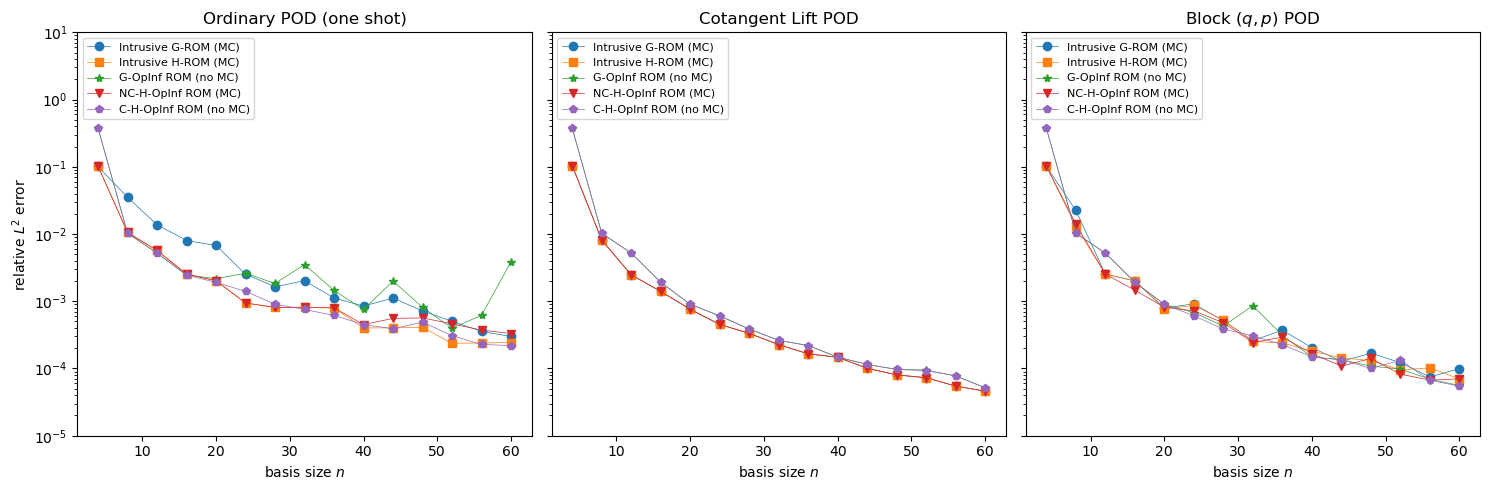

In [5]:
### Exact solution
Ttest     = 10
NtTest    = 501
tTest     = np.linspace(0, Ttest, NtTest)
ic  = ICgrid[0]
Xac = ru.integrate_Linear_HFOM(tTest, ic, L, A)[0]
dx  = xTrain[1]-xTrain[0]
exactE = Hamil(Xac, dx)

### Parameters
# oneShotList = [True, True, True]
oneShotList = [True, False, False]
UmatList    = [UU, [UU2,UU2], [UUq,UUp]]
SigmaList   = [SS, None, None]
MCtog       = [True, True, True]
if any(MCtog):
    UmatListMC = [UUmc, [UU2mc, UU2mc], [UUqmc, UUpmc]]

nList = [4*(i+1) for i in range(15)]
eIntG  = np.zeros((3, len(nList)))
eIntH  = np.zeros((3, len(nList)))
eOpH   = np.zeros((3, len(nList)))
eOp    = np.zeros((3, len(nList)))
eOpA   = np.zeros((3, len(nList)))

HamileIntG = np.zeros((3, len(nList), NtTest))
HamileIntH = np.zeros((3, len(nList), NtTest))
HamileOpH  = np.zeros((3, len(nList), NtTest))
HamileOp   = np.zeros((3, len(nList), NtTest))
HamileOpA  = np.zeros((3, len(nList), NtTest))

XrecIntG = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecIntH = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOp   = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOpH  = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOpA  = np.zeros((3, len(nList), 2*Nover2, NtTest))

fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
ax[0].set_ylabel('relative $L^2$ error')

titleList   = ['Ordinary POD (one shot)', 
               'Cotangent Lift POD',
               'Block $(q,p)$ POD']

alpha=1

for i in range(len(UmatList)):

    OpInfLists  = ou.build_OpInf_stuff(UmatList[i], X[:,:Nt], Xd[:,:Nt], 
                                        gH[:,:Nt], L, nList[-1])
    OpLists     = ru.build_Linear_ROM_Ops(UmatList[i], L, A, ic, MC=False)
    OpListOL    = list(OpLists[0])
    
    if MCtog[i]:
        OpInfListMC = ou.build_OpInf_stuff(UmatListMC[i], X[:,:Nt], Xd[:,:Nt], 
                                           gH[:,:Nt], L, nList[-1], MC=True)
        OpListsMC   = ru.build_Linear_ROM_Ops(UmatListMC[i], L, A, ic, MC=True)
        OpListMCOL  = list(OpListsMC[0])

    if oneShotList[i]:
        # Compute once and for all
        if MCtog[i]:
            LhatHOpFullMC = ou.NC_H_OpInf(OpInfListMC, nList[-1], eps=0.0e-12)
        else:
            LhatHOpFull   = ou.NC_H_OpInf(OpInfLists[0], nList[-1], eps=0.0e-12)
        
        AhatOpFull        = ou.C_H_OpInf(OpInfLists[1], nList[-1], SigmaList[i], eps=0.0e-12,)

    DhatOpFull            = ou.G_OpInf(OpInfLists[-1], nList[-1], SigmaList[i], eps=0.0e-6)

    for j,n in enumerate(nList):

        if not oneShotList[i]:
            # Compute for each n
            DhatOp  = ou.G_OpInf(OpInfLists[-1], n, SigmaList[i], eps=0.0e-6)
            if MCtog[i]:
                LhatHOpMC = ou.NC_H_OpInf(OpInfListMC, n, eps=0.0e-12)
            else:
                LhatHOp   = ou.NC_H_OpInf(OpInfLists[0], n, eps=0.0e-12)
            
            AhatOp        = ou.C_H_OpInf(OpInfLists[1], n, SigmaList[i], eps=0.0e-12, BorisZhu=False)
        else:
            if isinstance(UmatList[i], list):
                Ablock1 = AhatOpFull[:n//2, :n//2]
                idx = nList[-1]//2
                Ablock2 = AhatOpFull[idx:idx+n//2,idx:idx+n//2]
                AhatOp  = csc_matrix(np.block([[Ablock1, np.zeros((n//2,n//2))], 
                                              [np.zeros((n//2,n//2)), Ablock2]]))

                Dblock1 = DhatOpFull[:n//2, :n//2]
                idx = nList[-1]//2
                Dblock2 = DhatOpFull[idx:idx+n//2,idx:idx+n//2]
                DhatOp  = csc_matrix(np.block([[Dblock1, np.zeros((n//2,n//2))], 
                                              [np.zeros((n//2,n//2)), Dblock2]]))
                                              
            else:
                DhatOp        = DhatOpFull[:n,:n]
                AhatOp        = AhatOpFull[:n,:n]

            if MCtog[i]:
                LhatHOpMC = LhatHOpFullMC[:n,:n]
            else:
                LhatHOp   = LhatHOpFull[:n,:n]
        
        if MCtog[i]:
            OpListMCOL[0] = LhatHOpMC
            XrecIntG[i,j] = ru.integrate_Linear_ROM(tTest, OpListsMC[1], ic, UmatListMC[i], n, MC=True)
            XrecIntH[i,j] = ru.integrate_Linear_ROM(tTest, OpListsMC[0], ic, UmatListMC[i],
                                                    n, MC=True, Hamiltonian=True)
            XrecOpH[i,j]  = ru.integrate_Linear_ROM(tTest, OpListMCOL, ic, UmatListMC[i],
                                                    n, MC=True, Hamiltonian=True)
        else:
            OpListOL[0] = LhatHOp
            XrecIntG[i,j] = ru.integrate_Linear_ROM(tTest, OpLists[1], ic, UmatList[i], n, MC=False)
            XrecIntH[i,j] = ru.integrate_Linear_ROM(tTest, OpLists[0], ic, UmatList[i],
                                                    n, MC=False, Hamiltonian=True)
            XrecOpH[i,j]  = ru.integrate_Linear_ROM(tTest, OpListOL, ic, UmatList[i],
                                                    n, MC=False, Hamiltonian=True)

        XrecOp[i,j]   = ru.integrate_OpInf_ROM(tTest, DhatOp, ic, UmatList[i])
        XrecOpA[i,j]  = ru.integrate_OpInf_ROM(tTest, AhatOp, ic, UmatList[i], L)

        eIntG[i,j] = ru.relError(Xac, XrecIntG[i,j])
        eIntH[i,j] = ru.relError(Xac, XrecIntH[i,j])
        eOp[i,j]   = ru.relError(Xac, XrecOp[i,j])
        eOpH[i,j]  = ru.relError(Xac, XrecOpH[i,j])
        eOpA[i,j]  = ru.relError(Xac, XrecOpA[i,j])

        HamileIntG[i,j] = np.abs(Hamil(XrecIntG[i,j], dx) - exactE)
        HamileIntH[i,j] = np.abs(Hamil(XrecIntH[i,j], dx) - exactE)
        HamileOp[i,j]   = np.abs(Hamil(XrecOp[i,j], dx) - exactE)
        HamileOpH[i,j]  = np.abs(Hamil(XrecOpH[i,j], dx) - exactE)
        HamileOpA[i,j]  = np.abs(Hamil(XrecOpA[i,j], dx) - exactE)

        HamileIntG[i,j] = Hamil(XrecIntG[i,j], dx)
        HamileIntH[i,j] = Hamil(XrecIntH[i,j], dx)
        HamileOp[i,j]   = Hamil(XrecOp[i,j], dx)
        HamileOpH[i,j]  = Hamil(XrecOpH[i,j], dx)
        HamileOpA[i,j]  = Hamil(XrecOpA[i,j], dx)

    # Print error magnitudes
    print(f'{i} the relative L2 errors for intrusive GROM are {eIntG[i]}')
    print(f'{i} the relative L2 errors for intrusive HROM are {eIntH[i]}')
    print(f'{i} the relative L2 errors for generic OpInf are {eOp[i]}')
    print(f'{i} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH[i]}')
    print(f'{i} the relative L2 errors for canonical Hamiltonian OpInf are {eOpA[i]}' + '\n')

    ax.flatten()[i].semilogy(nList, eIntG[i], label='Intrusive G-ROM (MC)', marker='o', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eIntH[i], label='Intrusive H-ROM (MC)', marker='s', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOp[i],  label='G-OpInf ROM (no MC)', marker='*', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpH[i], label='NC-H-OpInf ROM (MC)', marker='v', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpA[i], label='C-H-OpInf ROM (no MC)', marker='p', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].set_ylim([10**-5, 10.])
    ax.flatten()[i].set_title(f'{titleList[i]}')
    ax.flatten()[i].legend(prop={'size':8}, loc=2)
    ax.flatten()[i].set_xlabel('basis size $n$')

plt.tight_layout()
# plt.savefig(f'WavePlotT{Ttest}', transparent=True)
plt.show()

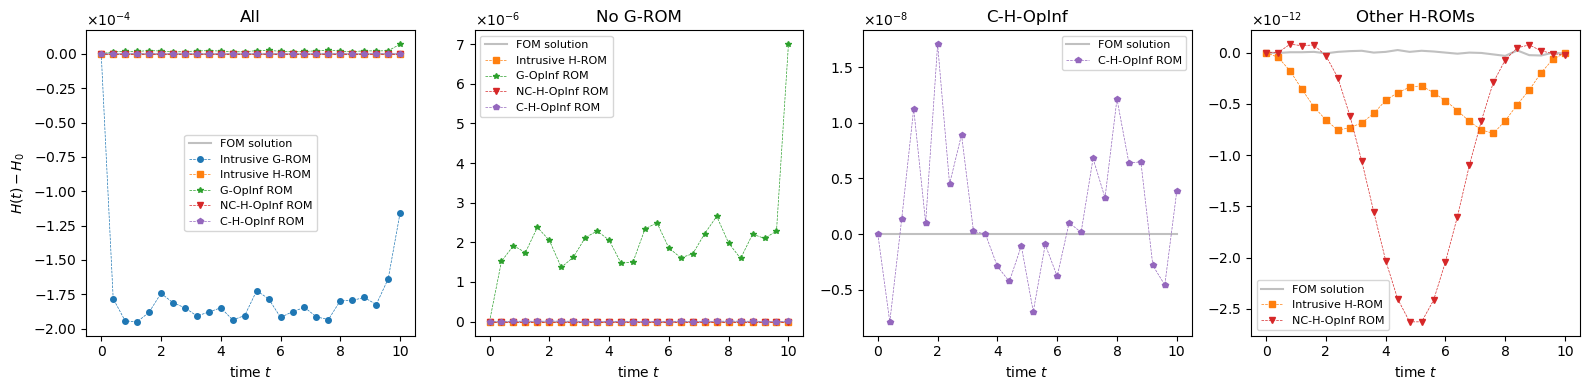

/var/folders/fm/5nmtz1sx0qgfhs9hqsd70ycc00434g/T/ipykernel_82368/741155005.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


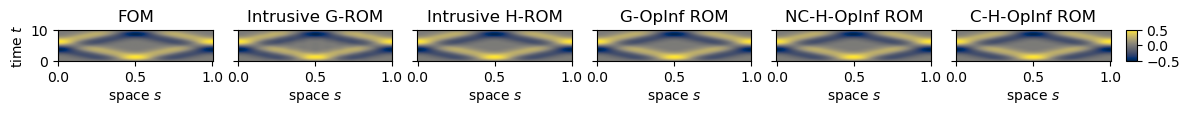

In [6]:
name = "tab10"
cmap = plt.get_cmap(name)

plt.rcParams['axes.formatter.useoffset'] = True 

fig, ax = plt.subplots(1, 4, figsize=(16,4), sharex=True)
ax.flatten()[0].set_ylabel(r'$H(t) - H_0$')

skip=20
i,j = 2,3

titleList   = ['All', 
               'No G-ROM',
               'C-H-OpInf' , 
               'Other H-ROMs']

ax.flatten()[0].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[0].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0],  label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[1].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[1].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[2].plot(tTest[::skip], exactE[::skip]-exactE[::skip], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[2].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[3].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[i].set_ylim([10**-5, 10**3.])
for i in range(4):
    ax.flatten()[i].set_title(f'{titleList[i]}', y=1.0)
    ax.flatten()[i].legend(prop={'size':8})
    ax.flatten()[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    ax.flatten()[i].set_xlabel('time $t$')
    # ax.flatten()[i].yaxis.set_major_formatter(y_formatter)
    # ax.flatten()[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2g'))
plt.tight_layout()
# plt.savefig(f'Energy{4*(j+1)}modesT{Ttest}', transparent=True)
plt.show()


i,j = 0,3
dx = xTrain[1]-xTrain[0]
dt = tTest[1]-tTest[0]
extent = [xTrain[0]-dx, xTrain[-1]+dx, tTest[0]-dt, tTest[-1]+dt]

titleList = ['FOM', 'Intrusive G-ROM', 'Intrusive H-ROM', 'G-OpInf ROM', 'NC-H-OpInf ROM', 'C-H-OpInf ROM']

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12,4))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,6),
                 axes_pad=0.25,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                )

im = grid[0].imshow(Xac[Nover2:].T, extent=extent, aspect=0.02*(Xac[:Nover2].shape[0]/Xac[:Nover2].shape[1]), cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[1].imshow(XrecIntG[i,j][Nover2:].T, extent=extent, aspect=0.02*(Xac[:Nover2].shape[0]/Xac[:Nover2].shape[1]), cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[2].imshow(XrecIntH[i,j][Nover2:].T, extent=extent, aspect=0.02*(Xac[:Nover2].shape[0]/Xac[:Nover2].shape[1]), cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[3].imshow(XrecOp[i,j][Nover2:].T, extent=extent, aspect=0.02*(Xac[:Nover2].shape[0]/Xac[:Nover2].shape[1]), cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[4].imshow(XrecOpH[i,j][Nover2:].T, extent=extent, aspect=0.02*(Xac[:Nover2].shape[0]/Xac[:Nover2].shape[1]), cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[5].imshow(XrecOpA[i,j][Nover2:].T, extent=extent, aspect=0.02*(Xac[:Nover2].shape[0]/Xac[:Nover2].shape[1]), cmap='cividis', vmin=-0.5, vmax=0.5)
for i in range(6):
    grid[i].set_title(f'{titleList[i]}')
    grid[i].set_xlabel('space $s$')
grid[0].set_ylabel('time $t$')

grid[-1].cax.colorbar(im)
grid[-1].cax.toggle_label(True)

plt.tight_layout()
# plt.savefig(f'WaveImshow{4*(j+1)}ModesT{Ttest}', transparent=True, bbox_inches='tight')
plt.show()

### Testing the nonparametric version (T=100)

With and without mean centering, symplectic lift, and one shot OpInf.

Script takes about 30s.

0 the relative L2 errors for intrusive GROM are [0.13432283 0.36821657 0.13935012 0.07670262 0.04143151 0.01200137
 0.00978377 0.06843734 0.00737591 0.00533279 0.0122519  0.0031709
 0.00282271 0.00266923 0.00907279]
0 the relative L2 errors for intrusive HROM are [0.1370034  0.01132611 0.01185088 0.00300944 0.00348966 0.00145412
 0.00130213 0.00131254 0.00107819 0.00066641 0.00067245 0.00058662
 0.00046316 0.00051661 0.00043036]
0 the relative L2 errors for generic OpInf are [3.76012185e-01 1.05276139e-02 5.74380621e-03 8.22960552e-03
 2.73940844e-01 5.96820683e+03 1.71954811e+05 2.25852568e+09
 1.42480046e+05 7.80673537e+05 1.20650214e+08 9.36267962e+06
 5.97503698e+03 1.90138161e+07 3.61076637e+16]
0 the relative L2 errors for noncanonical Hamiltonian OpInf are [0.1370034  0.01132612 0.01185115 0.00300947 0.00348996 0.00143498
 0.00132568 0.00134009 0.0011101  0.00220157 0.00139805 0.00065801
 0.00068501 0.00058548 0.00054734]
0 the relative L2 errors for canonical Hamiltonian OpInf 

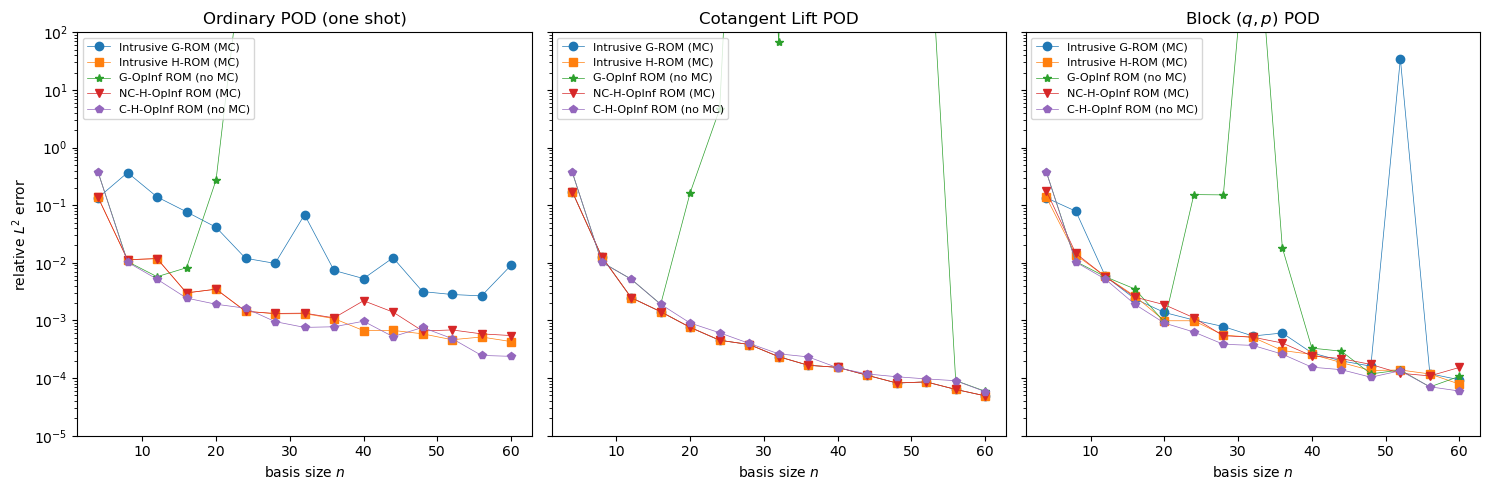

In [5]:
### Exact solution
Ttest     = 100
NtTest    = 1001
tTest     = np.linspace(0, Ttest, NtTest)
ic  = ICgrid[0]
Xac = ru.integrate_Linear_HFOM(tTest, ic, L, A)[0]
dx  = xTrain[1]-xTrain[0]
exactE = Hamil(Xac, dx)

### Parameters
# oneShotList = [True, True, True]
oneShotList = [True, False, False]
UmatList    = [UU, [UU2,UU2], [UUq,UUp]]
SigmaList   = [SS, None, None]
MCtog       = [True, True, True]
if any(MCtog):
    UmatListMC = [UUmc, [UU2mc, UU2mc], [UUqmc, UUpmc]]

nList = [4*(i+1) for i in range(15)]
eIntG  = np.zeros((3, len(nList)))
eIntH  = np.zeros((3, len(nList)))
eOpH   = np.zeros((3, len(nList)))
eOp    = np.zeros((3, len(nList)))
eOpA   = np.zeros((3, len(nList)))

HamileIntG = np.zeros((3, len(nList), NtTest))
HamileIntH = np.zeros((3, len(nList), NtTest))
HamileOpH  = np.zeros((3, len(nList), NtTest))
HamileOp   = np.zeros((3, len(nList), NtTest))
HamileOpA  = np.zeros((3, len(nList), NtTest))

XrecIntG = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecIntH = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOp   = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOpH  = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOpA  = np.zeros((3, len(nList), 2*Nover2, NtTest))

fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
ax[0].set_ylabel('relative $L^2$ error')

titleList   = ['Ordinary POD (one shot)', 
               'Cotangent Lift POD',
               'Block $(q,p)$ POD']

alpha=1

for i in range(len(UmatList)):

    OpInfLists  = ou.build_OpInf_stuff(UmatList[i], X[:,:Nt], Xd[:,:Nt], 
                                        gH[:,:Nt], L, nList[-1])
    OpLists     = ru.build_Linear_ROM_Ops(UmatList[i], L, A, ic, MC=False)
    OpListOL    = list(OpLists[0])
    
    if MCtog[i]:
        OpInfListMC = ou.build_OpInf_stuff(UmatListMC[i], X[:,:Nt], Xd[:,:Nt], 
                                           gH[:,:Nt], L, nList[-1], MC=True)
        OpListsMC   = ru.build_Linear_ROM_Ops(UmatListMC[i], L, A, ic, MC=True)
        OpListMCOL  = list(OpListsMC[0])

    if oneShotList[i]:
        # Compute once and for all
        if MCtog[i]:
            LhatHOpFullMC = ou.NC_H_OpInf(OpInfListMC, nList[-1], eps=0.0e-12)
        else:
            LhatHOpFull   = ou.NC_H_OpInf(OpInfLists[0], nList[-1], eps=0.0e-12)
        
        AhatOpFull        = ou.C_H_OpInf(OpInfLists[1], nList[-1], SigmaList[i], eps=0.0e-12)

    DhatOpFull            = ou.G_OpInf(OpInfLists[-1], nList[-1], SigmaList[i], eps=0.0e-6)

    for j,n in enumerate(nList):

        if not oneShotList[i]:
            # Compute for each n
            DhatOp  = ou.G_OpInf(OpInfLists[-1], n, SigmaList[i], eps=0.0e-6)
            if MCtog[i]:
                LhatHOpMC = ou.NC_H_OpInf(OpInfListMC, n, eps=0.0e-12)
            else:
                LhatHOp   = ou.NC_H_OpInf(OpInfLists[0], n, eps=0.0e-12)
            
            AhatOp        = ou.C_H_OpInf(OpInfLists[1], n, SigmaList[i], eps=0.0e-12, BorisZhu=False)
        else:
            if isinstance(UmatList[i], list):
                Ablock1 = AhatOpFull[:n//2, :n//2]
                idx = nList[-1]//2
                Ablock2 = AhatOpFull[idx:idx+n//2,idx:idx+n//2]
                AhatOp  = csc_matrix(np.block([[Ablock1, np.zeros((n//2,n//2))], 
                                              [np.zeros((n//2,n//2)), Ablock2]]))

                Dblock1 = DhatOpFull[:n//2, :n//2]
                idx = nList[-1]//2
                Dblock2 = DhatOpFull[idx:idx+n//2,idx:idx+n//2]
                DhatOp  = csc_matrix(np.block([[Dblock1, np.zeros((n//2,n//2))], 
                                              [np.zeros((n//2,n//2)), Dblock2]]))
                                              
            else:
                DhatOp        = DhatOpFull[:n,:n]
                AhatOp        = AhatOpFull[:n,:n]

            if MCtog[i]:
                LhatHOpMC = LhatHOpFullMC[:n,:n]
            else:
                LhatHOp   = LhatHOpFull[:n,:n]
        
        if MCtog[i]:
            OpListMCOL[0] = LhatHOpMC
            XrecIntG[i,j] = ru.integrate_Linear_ROM(tTest, OpListsMC[1], ic, UmatListMC[i], n, MC=True)
            XrecIntH[i,j] = ru.integrate_Linear_ROM(tTest, OpListsMC[0], ic, UmatListMC[i],
                                                    n, MC=True, Hamiltonian=True)
            XrecOpH[i,j]  = ru.integrate_Linear_ROM(tTest, OpListMCOL, ic, UmatListMC[i],
                                                    n, MC=True, Hamiltonian=True)
        else:
            OpListOL[0] = LhatHOp
            XrecIntG[i,j] = ru.integrate_Linear_ROM(tTest, OpLists[1], ic, UmatList[i], n, MC=False)
            XrecIntH[i,j] = ru.integrate_Linear_ROM(tTest, OpLists[0], ic, UmatList[i],
                                                    n, MC=False, Hamiltonian=True)
            XrecOpH[i,j]  = ru.integrate_Linear_ROM(tTest, OpListOL, ic, UmatList[i],
                                                    n, MC=False, Hamiltonian=True)

        XrecOp[i,j]   = ru.integrate_OpInf_ROM(tTest, DhatOp, ic, UmatList[i])
        XrecOpA[i,j]  = ru.integrate_OpInf_ROM(tTest, AhatOp, ic, UmatList[i], L)

        eIntG[i,j] = ru.relError(Xac, XrecIntG[i,j])
        eIntH[i,j] = ru.relError(Xac, XrecIntH[i,j])
        eOp[i,j]   = ru.relError(Xac, XrecOp[i,j])
        eOpH[i,j]  = ru.relError(Xac, XrecOpH[i,j])
        eOpA[i,j]  = ru.relError(Xac, XrecOpA[i,j])

        HamileIntG[i,j] = np.abs(Hamil(XrecIntG[i,j], dx) - exactE)
        HamileIntH[i,j] = np.abs(Hamil(XrecIntH[i,j], dx) - exactE)
        HamileOp[i,j]   = np.abs(Hamil(XrecOp[i,j], dx) - exactE)
        HamileOpH[i,j]  = np.abs(Hamil(XrecOpH[i,j], dx) - exactE)
        HamileOpA[i,j]  = np.abs(Hamil(XrecOpA[i,j], dx) - exactE)

        HamileIntG[i,j] = Hamil(XrecIntG[i,j], dx)
        HamileIntH[i,j] = Hamil(XrecIntH[i,j], dx)
        HamileOp[i,j]   = Hamil(XrecOp[i,j], dx)
        HamileOpH[i,j]  = Hamil(XrecOpH[i,j], dx)
        HamileOpA[i,j]  = Hamil(XrecOpA[i,j], dx)

    # Print error magnitudes
    print(f'{i} the relative L2 errors for intrusive GROM are {eIntG[i]}')
    print(f'{i} the relative L2 errors for intrusive HROM are {eIntH[i]}')
    print(f'{i} the relative L2 errors for generic OpInf are {eOp[i]}')
    print(f'{i} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH[i]}')
    print(f'{i} the relative L2 errors for canonical Hamiltonian OpInf are {eOpA[i]}' + '\n')

    ax.flatten()[i].semilogy(nList, eIntG[i], label='Intrusive G-ROM (MC)', marker='o', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eIntH[i], label='Intrusive H-ROM (MC)', marker='s', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOp[i],  label='G-OpInf ROM (no MC)', marker='*', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpH[i], label='NC-H-OpInf ROM (MC)', marker='v', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpA[i], label='C-H-OpInf ROM (no MC)', marker='p', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].set_ylim([10**-5, 100.])
    ax.flatten()[i].set_title(f'{titleList[i]}')
    ax.flatten()[i].legend(prop={'size':8}, loc=2)
    ax.flatten()[i].set_xlabel('basis size $n$')

plt.tight_layout()
# plt.savefig(f'WavePlotT{Ttest}', transparent=True)
plt.show()

In [6]:
# ### Make movie of solutions
# i,j=1,4

# arrs = np.array([Xac[:Nover2], XrecIntH[i,j][:Nover2],
#                  XrecOp[i,j][:Nover2], XrecOpA[i,j][:Nover2]])
# styles = ['-', '--', '--', '-.']
# labels = ['FOM Solution', 'Intrusive H-ROM', 'OpInf ROM', 'OpInf H-ROM']

# animate_array(arrs, styles, labels, np.array(xTrain), legend_loc=3)

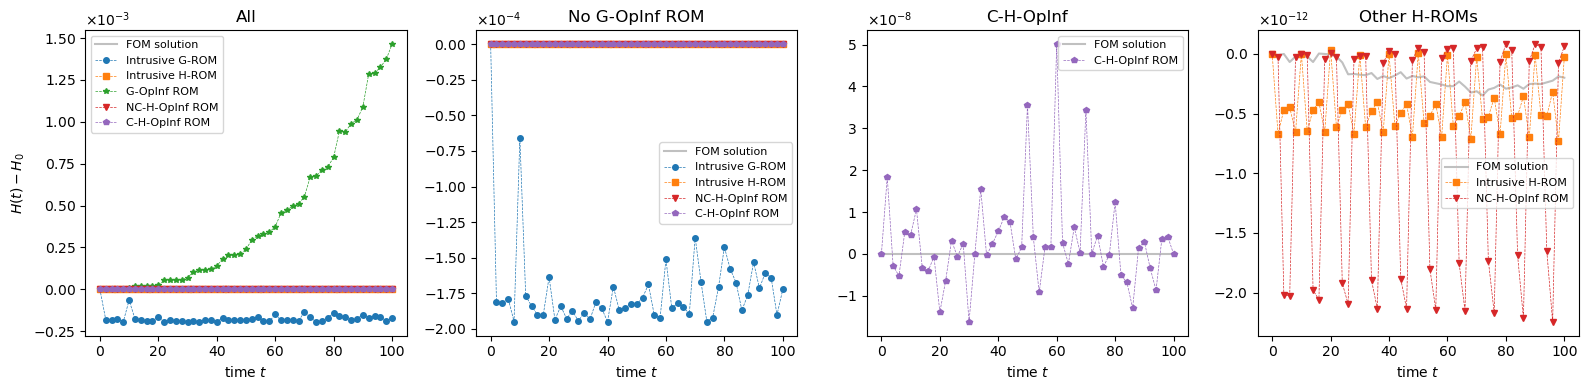

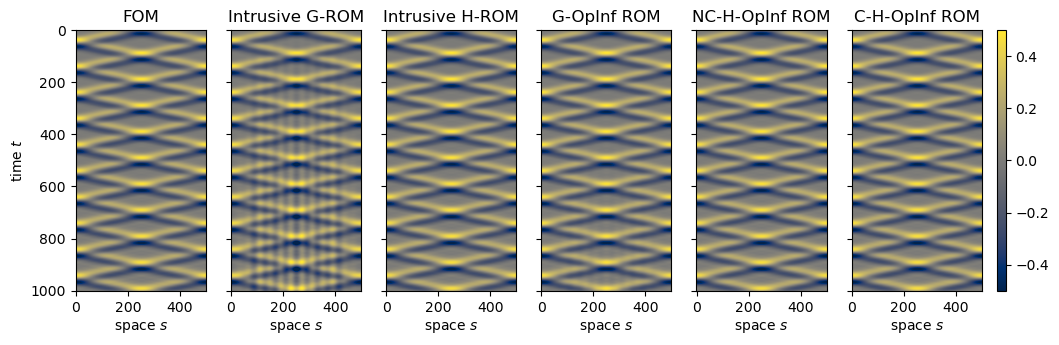

In [35]:
name = "tab10"
cmap = plt.get_cmap(name)

plt.rcParams['axes.formatter.useoffset'] = True 

fig, ax = plt.subplots(1, 4, figsize=(16,4), sharex=True)
ax.flatten()[0].set_ylabel(r'$H(t) - H_0$')

skip=20
i,j = 2,3

titleList   = ['All', 
               'No G-OpInf ROM',
               'C-H-OpInf' , 
               'Other H-ROMs']

ax.flatten()[0].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[0].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0],  label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[1].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[1].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[2].plot(tTest[::skip], exactE[::skip]-exactE[::skip], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[2].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[3].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[i].set_ylim([10**-5, 10**3.])
for i in range(4):
    ax.flatten()[i].set_title(f'{titleList[i]}', y=1.0)
    ax.flatten()[i].legend(prop={'size':8})
    ax.flatten()[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    ax.flatten()[i].set_xlabel('time $t$')
    # ax.flatten()[i].yaxis.set_major_formatter(y_formatter)
    # ax.flatten()[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2g'))
plt.tight_layout()
# plt.savefig(f'Energy{4*(j+1)}modesT{Ttest}', transparent=True)
plt.show()


i,j = 0,3
dx = xTrain[1]-xTrain[0]
dt = tTest[1]-tTest[0]
extent = [xTrain[0]-dx, xTrain[-1]+dx, tTest[0]-dt, tTest[-1]+dt]

titleList = ['FOM', 'Intrusive G-ROM', 'Intrusive H-ROM', 'G-OpInf ROM', 'NC-H-OpInf ROM', 'C-H-OpInf ROM']

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12.,8.))

grid = ImageGrid(fig, 111, 
                 nrows_ncols=(1,6),
                 axes_pad=0.25,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                )

im = grid[0].imshow(Xac[Nover2:].T, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[1].imshow(XrecIntG[i,j][Nover2:].T, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[2].imshow(XrecIntH[i,j][Nover2:].T, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[3].imshow(XrecOp[i,j][Nover2:].T, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[4].imshow(XrecOpH[i,j][Nover2:].T, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[5].imshow(XrecOpA[i,j][Nover2:].T, cmap='cividis', vmin=-0.5, vmax=0.5)
for i in range(6):
    grid[i].set_title(f'{titleList[i]}')
    grid[i].set_xlabel('space $s$')
grid[0].set_ylabel('time $t$')

grid[-1].cax.colorbar(im)
grid[-1].cax.toggle_label(True)

# plt.gcf().set_size_inches(12,8)

# plt.tight_layout()
# plt.savefig(f'WaveImshow{4*(j+1)}ModesT{Ttest}', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

## Parametric version

### Training the POD bases

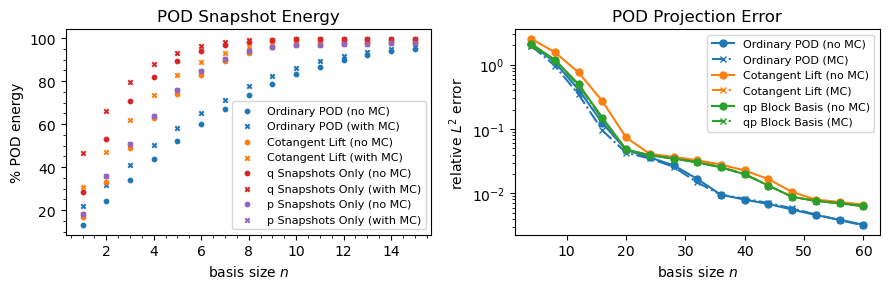

In [10]:
### Ordinary POD algo
UU, SS     = np.linalg.svd(X)[:2]
UUmc, SSmc = np.linalg.svd(Xmc)[:2]

### Symplectic lift algo:  U here is half the length of other one
Xlong   = np.concatenate((X[:Nover2],   X[Nover2:]),   axis=1)
Xmclong = np.concatenate((Xmc[:Nover2], Xmc[Nover2:]), axis=1)
UU2, SS2     = np.linalg.svd(Xlong)[:2]
UU2mc, SS2mc = np.linalg.svd(Xmclong)[:2]

### Block q,p algo
UUq, SSq = np.linalg.svd(X[:Nover2])[:2]
UUqmc, SSqmc = np.linalg.svd(Xmc[:Nover2])[:2]
UUp, SSp = np.linalg.svd(X[Nover2:])[:2]
UUpmc, SSpmc = np.linalg.svd(Xmc[Nover2:])[:2]


nEigs = 15
idx = [i+1 for i in range(nEigs)]
X1 = X.reshape(-1, npts, Nt)
X1 = X1.transpose((1,0,2))

name = "tab10"
cmap = plt.get_cmap(name)

nList   = [4*(i+1) for i in range(15)]
errU    = np.zeros((len(nList), npts))
errUmc  = np.zeros((len(nList), npts))
errU2   = np.zeros((len(nList), npts))
errU2mc = np.zeros((len(nList), npts))
errUqp  = np.zeros((len(nList), npts))
errUqpmc = np.zeros((len(nList), npts))
for i,n in enumerate(nList):
    Umc   = UUmc[:,:n]
    U     = UU[:,:n]
    Ub    = UU2mc[:,:n//2]
    Zb    = np.zeros_like(Ub)
    U2mc = csc_matrix(np.block([[Ub, Zb], [Zb, Ub]]))
    Ub    = UU2[:,:n//2]
    Zb    = np.zeros_like(Ub)
    U2    = csc_matrix(np.block([[Ub, Zb], [Zb, Ub]]))
    Uq    = UUqmc[:,:n//2]
    Up    = UUpmc[:,:n//2]
    Zb    = np.zeros_like(Uq)
    Uqpmc = csc_matrix(np.block([[Uq, Zb], [Zb, Up]]))
    Uq    = UUq[:,:n//2]
    Up    = UUp[:,:n//2]
    Zb    = np.zeros_like(Uq)
    Uqp   = csc_matrix(np.block([[Uq, Zb], [Zb, Up]]))

    for j, snaps in enumerate(X1):
        ic = ICgrid[j]

        reconUmc   = ic.reshape(-1,1) + Umc @ Umc.T @ (snaps - ic.reshape(-1,1))
        reconU     = U @ U.T @ snaps
        reconU2mc  = ic.reshape(-1,1) + U2mc @ U2mc.T @ (snaps - ic.reshape(-1,1))
        reconU2    = U2 @ U2.T @ snaps
        reconUqpmc = ic.reshape(-1,1) + Uqpmc @ Uqpmc.T @ (snaps - ic.reshape(-1,1))
        reconUqp   = Uqp @ Uqp.T @ snaps

        errUmc[i,j]   = ru.relError(snaps, reconUmc)
        errU[i,j]     = ru.relError(snaps, reconU)
        errU2mc[i,j]  = ru.relError(snaps, reconU2mc)
        errU2[i,j]    = ru.relError(snaps, reconU2)
        errUqpmc[i,j] = ru.relError(snaps, reconUqpmc)
        errUqp[i,j]   = ru.relError(snaps, reconUqp)

from matplotlib.ticker import StrMethodFormatter

fig, ax = plt.subplots(1, 2, figsize=(9,3))

ax[0].set_title('POD Snapshot Energy')
ax[0].scatter(idx, np.cumsum(SS[:nEigs] / np.sum(SS))*100, s=10., label='Ordinary POD (no MC)', color=cmap.colors[0])
ax[0].scatter(idx, np.cumsum(SSmc[:nEigs] / np.sum(SSmc))*100, s=10., label='Ordinary POD (with MC)', marker='x', color=cmap.colors[0])
ax[0].scatter(idx, np.cumsum(SS2[:nEigs] / np.sum(SS2))*100, s=10., label='Cotangent Lift (no MC)', color=cmap.colors[1])
ax[0].scatter(idx, np.cumsum(SS2mc[:nEigs] / np.sum(SS2mc))*100, s=10., label='Cotangent Lift (with MC)', marker='x', color=cmap.colors[1])
ax[0].scatter(idx, np.cumsum(SSq[:nEigs] / np.sum(SSq))*100, s=10., label='q Snapshots Only (no MC)', color=cmap.colors[3])
ax[0].scatter(idx, np.cumsum(SSqmc[:nEigs] / np.sum(SSqmc))*100, s=10., label='q Snapshots Only (with MC)', marker='x', color=cmap.colors[3])
ax[0].scatter(idx, np.cumsum(SSp[:nEigs] / np.sum(SSp))*100, s=10., label='p Snapshots Only (no MC)', color=cmap.colors[4])
ax[0].scatter(idx, np.cumsum(SSpmc[:nEigs] / np.sum(SSpmc))*100, s=10., label='p Snapshots Only (with MC)', marker='x', color=cmap.colors[4])
ax[0].legend(prop={'size': 8})

ax[1].set_title('POD Projection Error')
ax[1].semilogy(nList, np.linalg.norm(errU, axis=1), label='Ordinary POD (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, np.linalg.norm(errUmc, axis=1), label='Ordinary POD (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, np.linalg.norm(errU2, axis=1), label='Cotangent Lift (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, np.linalg.norm(errU2mc, axis=1), label='Cotangent Lift (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, np.linalg.norm(errUqp, axis=1), label='qp Block Basis (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[2])
ax[1].semilogy(nList, np.linalg.norm(errUqpmc, axis=1), label='qp Block Basis (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[2])
ax[1].set_title('POD Projection Error')
ax[1].set_ylabel('relative $L^2$ error')
ax[1].legend(prop={'size': 8})

# ax[0].get_shared_y_axes().join(ax[0], ax[1])
# ax[1].set_xticklabels([])
for i in range(1):
    ax[i].minorticks_on()
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax[i].set_ylabel('% POD energy')
for i in range(2):
    ax[i].set_xlabel('basis size $n$')
plt.tight_layout()
# plt.savefig('WavePODenergyParam', transparent=True)
plt.show()

### Testing the parametric version

First cell tests symplectic lift version, second tests standard version

In [11]:
# Generating Test Data
Ttest     = 100
NtTest    = 501
tTest     = np.linspace(0, Ttest, NtTest)

nTestPts   = 6
aRangeTest = np.linspace(5.5, 14.5, nTestPts)
ICgridTest = np.zeros((len(aRangeTest), Nover2*2))

for i,a in enumerate(aRangeTest):
    ICgridTest[i] = np.concatenate((h(s(xTrain, a, 0.5)), 
                                        np.zeros(Nover2)), axis=0)

Xtest, XdTest, gHtest  = ru.integrate_Linear_HFOM(tTest, ICgridTest[0], L, A)

for i,ic in enumerate(ICgridTest[1:]):
    sol, soldot, grad = ru.integrate_Linear_HFOM(tTest, ic, L, A)
    Xtest  = np.concatenate((Xtest,  sol),    axis=1)
    XdTest = np.concatenate((XdTest, soldot), axis=1)
    gHtest = np.concatenate((gHtest, grad),   axis=1)

Xac = Xtest.reshape(-1, nTestPts, NtTest)

print(f'train points are {aRange}')
print(f'test points are {aRangeTest}')

train points are [ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
test points are [ 5.5  7.3  9.1 10.9 12.7 14.5]


0 the relative L2 errors for intrusive GROM are [ 3.69772511 22.41248887 15.5491109   7.23528455  2.62866159  4.24281269
  4.40054713  3.3702733   2.37280115  1.62862116  1.66757551  1.23704147
  0.97360076  0.56312324  0.35058877]
0 the relative L2 errors for intrusive HROM are [1.25080017 0.80425777 0.42682737 0.1536018  0.03313093 0.03340339
 0.0342669  0.02175561 0.01572534 0.01546116 0.0154642  0.01549698
 0.01684216 0.01507492 0.01348502]
0 the relative L2 errors for generic OpInf are [1.05460819e+00 5.68684355e-01 2.71390408e-01 1.06563579e-01
 4.30595116e-02 1.19778712e-01 1.26411243e+02 2.60090576e+03
 8.31018709e+08 1.74514452e+14 2.21404467e+09 1.69351849e+11
 3.37702348e+08 2.72151079e+11 7.50581818e+05]
0 the relative L2 errors for noncanonical Hamiltonian OpInf are [1.25080019 0.80425738 0.42682629 0.15360797 0.03388203 0.03427308
 0.03524762 0.02233019 0.01625942 0.01649115 0.01674896 0.0170521
 0.01652642 0.01754264 0.01736158]
0 the relative L2 errors for canonical Ham

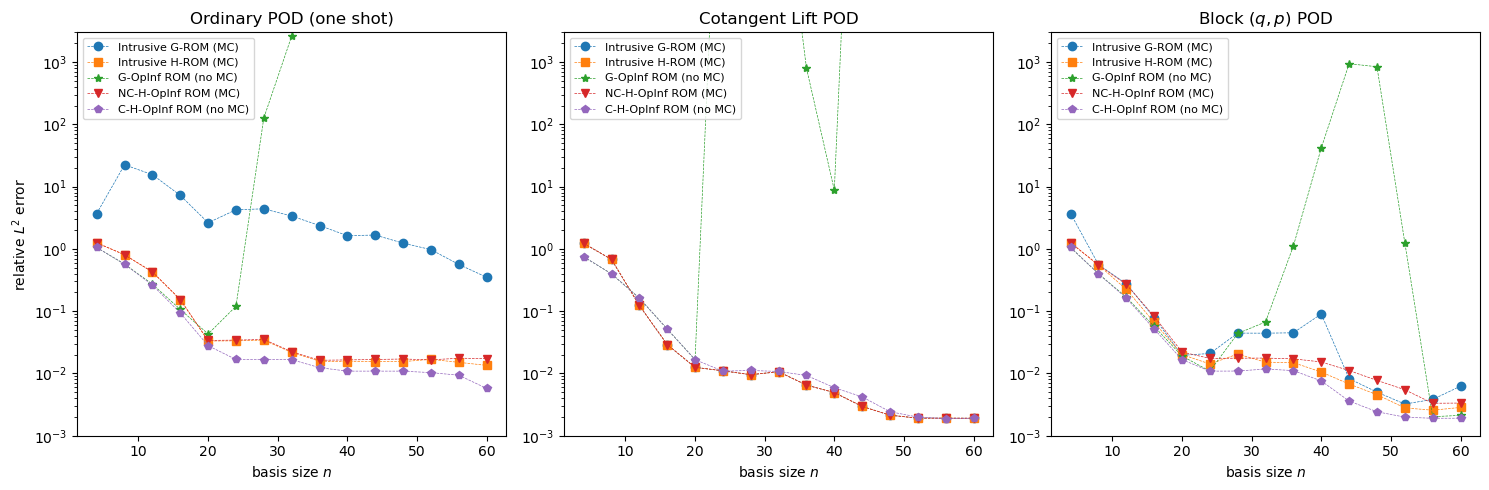

In [12]:
### Exact solution
dx  = xTrain[1]-xTrain[0]

### Parameters
# oneShotList = [True, True, True]
oneShotList = [True, False, False]
UmatList    = [UU, [UU2,UU2], [UUq,UUp]]
SigmaList   = [SS, None, None]
MCtog       = [True, True, True]
if any(MCtog):
    UmatListMC = [UUmc, [UU2mc, UU2mc], [UUqmc, UUpmc]]

nList = [4*(i+1) for i in range(15)]
eIntG  = np.zeros((3, nTestPts, len(nList)))
eIntH  = np.zeros((3, nTestPts, len(nList)))
eOpH   = np.zeros((3, nTestPts, len(nList)))
eOp    = np.zeros((3, nTestPts, len(nList)))
eOpA   = np.zeros((3, nTestPts, len(nList)))


exactE     = np.zeros((nTestPts, NtTest))
HamileIntG = np.zeros((3, nTestPts, len(nList), NtTest))
HamileIntH = np.zeros((3, nTestPts, len(nList), NtTest))
HamileOpH  = np.zeros((3, nTestPts, len(nList), NtTest))
HamileOp   = np.zeros((3, nTestPts, len(nList), NtTest))
HamileOpA  = np.zeros((3, nTestPts, len(nList), NtTest))

XrecIntG = np.zeros((3, nTestPts, len(nList), 2*Nover2, NtTest))
XrecIntH = np.zeros((3, nTestPts, len(nList), 2*Nover2, NtTest))
XrecOp   = np.zeros((3, nTestPts, len(nList), 2*Nover2, NtTest))
XrecOpH  = np.zeros((3, nTestPts, len(nList), 2*Nover2, NtTest))
XrecOpA  = np.zeros((3, nTestPts, len(nList), 2*Nover2, NtTest))

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].set_ylabel('relative $L^2$ error')

titleList   = ['Ordinary POD (one shot)', 
               'Cotangent Lift POD',
               'Block $(q,p)$ POD']

alpha=1

for i in range(len(UmatList)):

    OpInfLists  = ou.build_OpInf_stuff(UmatList[i], X, Xd, 
                                        gH, L, nList[-1])
    
    if MCtog[i]:
        OpInfListMC = ou.build_OpInf_stuff(UmatListMC[i], X, Xd, 
                                           gH, L, nList[-1], MC=True)

    if oneShotList[i]:
        # Compute once and for all
        if MCtog[i]:
            LhatHOpFullMC = ou.NC_H_OpInf(OpInfListMC, nList[-1], eps=0.0e-12)
        else:
            LhatHOpFull   = ou.NC_H_OpInf(OpInfLists[0], nList[-1], eps=0.0e-12)
        
        AhatOpFull        = ou.C_H_OpInf(OpInfLists[1], nList[-1], SigmaList[i], eps=0.0e-12)

    DhatOpFull            = ou.G_OpInf(OpInfLists[-1], nList[-1], SigmaList[i], eps=0.0e-6)


    for j,snaps in enumerate(Xac.transpose((1,0,2))):
        
        exactE[j] = Hamil(snaps, dx)
        ic = ICgridTest[j]

        OpLists     = ru.build_Linear_ROM_Ops(UmatList[i], L, A, ic, MC=False)
        OpListOL    = list(OpLists[0])

        if MCtog[i]:
            OpListsMC   = ru.build_Linear_ROM_Ops(UmatListMC[i], L, A, ic, MC=True)
            OpListMCOL  = list(OpListsMC[0])

        for k,n in enumerate(nList):

            if not oneShotList[i]:
                # Compute for each n
                DhatOp  = ou.G_OpInf(OpInfLists[-1], n, SigmaList[i], eps=0.0e-6)
                if MCtog[i]:
                    LhatHOpMC = ou.NC_H_OpInf(OpInfListMC, n, eps=0.0e-12)
                else:
                    LhatHOp   = ou.NC_H_OpInf(OpInfLists[0], n, eps=0.0e-12)
                
                AhatOp        = ou.C_H_OpInf(OpInfLists[1], n, SigmaList[i], eps=0.0e-12, BorisZhu=False)
            else:
                if isinstance(UmatList[i], list):
                    Ablock1 = AhatOpFull[:n//2, :n//2]
                    idx = nList[-1]//2
                    Ablock2 = AhatOpFull[idx:idx+n//2,idx:idx+n//2]
                    AhatOp  = csc_matrix(np.block([[Ablock1, np.zeros((n//2,n//2))], 
                                                [np.zeros((n//2,n//2)), Ablock2]]))

                    Dblock1 = DhatOpFull[:n//2, :n//2]
                    idx = nList[-1]//2
                    Dblock2 = DhatOpFull[idx:idx+n//2,idx:idx+n//2]
                    DhatOp  = csc_matrix(np.block([[Dblock1, np.zeros((n//2,n//2))], 
                                                [np.zeros((n//2,n//2)), Dblock2]]))

                else:
                    DhatOp        = DhatOpFull[:n,:n]
                    AhatOp        = AhatOpFull[:n,:n]

                if MCtog[i]:
                    LhatHOpMC = LhatHOpFullMC[:n,:n]
                else:
                    LhatHOp   = LhatHOpFull[:n,:n]
        

            if MCtog[i]:
                OpListMCOL[0] = LhatHOpMC
                XrecIntG[i,j,k] = ru.integrate_Linear_ROM(tTest, OpListsMC[1], ic, UmatListMC[i], n, MC=True)
                XrecIntH[i,j,k] = ru.integrate_Linear_ROM(tTest, OpListsMC[0], ic, UmatListMC[i],
                                                        n, MC=True, Hamiltonian=True)
                XrecOpH[i,j,k]  = ru.integrate_Linear_ROM(tTest, OpListMCOL, ic, UmatListMC[i],
                                                        n, MC=True, Hamiltonian=True)
            else:
                OpListOL[0] = LhatHOp
                XrecIntG[i,j,k] = ru.integrate_Linear_ROM(tTest, OpLists[1], ic, UmatList[i], n, MC=False)
                XrecIntH[i,j,k] = ru.integrate_Linear_ROM(tTest, OpLists[0], ic, UmatList[i],
                                                        n, MC=False, Hamiltonian=True)
                XrecOpH[i,j,k]  = ru.integrate_Linear_ROM(tTest, OpListOL, ic, UmatList[i],
                                                        n, MC=False, Hamiltonian=True)

            XrecOp[i,j,k]   = ru.integrate_OpInf_ROM(tTest, DhatOp, ic, UmatList[i])
            XrecOpA[i,j,k]  = ru.integrate_OpInf_ROM(tTest, AhatOp, ic, UmatList[i], L)

            eIntG[i,j,k] = ru.relError(snaps, XrecIntG[i,j,k])
            eIntH[i,j,k] = ru.relError(snaps, XrecIntH[i,j,k])
            eOp[i,j,k]   = ru.relError(snaps, XrecOp[i,j,k])
            eOpH[i,j,k]  = ru.relError(snaps, XrecOpH[i,j,k])
            eOpA[i,j,k]  = ru.relError(snaps, XrecOpA[i,j,k])

            # HamileIntG[i,j,k] = np.abs(Hamil(XrecIntG[i,j,k], dx) - exactE)
            # HamileIntH[i,j,k] = np.abs(Hamil(XrecIntH[i,j,k], dx) - exactE)
            # HamileOp[i,j,k]   = np.abs(Hamil(XrecOp[i,j,k], dx) - exactE)
            # HamileOpH[i,j,k]  = np.abs(Hamil(XrecOpH[i,j,k], dx) - exactE)
            # HamileOpA[i,j,k]  = np.abs(Hamil(XrecOpA[i,j,k], dx) - exactE)
    
            HamileIntG[i,j,k] = Hamil(XrecIntG[i,j,k], dx)
            HamileIntH[i,j,k] = Hamil(XrecIntH[i,j,k], dx)
            HamileOp[i,j,k]   = Hamil(XrecOp[i,j,k], dx)
            HamileOpH[i,j,k]  = Hamil(XrecOpH[i,j,k], dx)
            HamileOpA[i,j,k]  = Hamil(XrecOpA[i,j,k], dx)

eIntGi = np.mean(eIntG, axis=1)
eIntHi = np.mean(eIntH, axis=1)
eOpi   = np.mean(eOp, axis=1)
eOpHi  = np.mean(eOpH, axis=1)
eOpAi  = np.mean(eOpA, axis=1)

for i in range(3):
    # Print error magnitudes
    print(f'{i} the relative L2 errors for intrusive GROM are {eIntGi[i]}')
    print(f'{i} the relative L2 errors for intrusive HROM are {eIntHi[i]}')
    print(f'{i} the relative L2 errors for generic OpInf are {eOpi[i]}')
    print(f'{i} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpHi[i]}')
    print(f'{i} the relative L2 errors for canonical Hamiltonian OpInf are {eOpAi[i]}' + '\n')

    ax.flatten()[i].semilogy(nList, eIntGi[i], label='Intrusive G-ROM (MC)', marker='o', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eIntHi[i], label='Intrusive H-ROM (MC)', marker='s', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpi[i],  label='G-OpInf ROM (no MC)', marker='*', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpHi[i], label='NC-H-OpInf ROM (MC)', marker='v', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpAi[i], label='C-H-OpInf ROM (no MC)', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].set_ylim([10**-3, 3*10**3])
    ax.flatten()[i].set_title(f'{titleList[i]}')
    ax.flatten()[i].legend(prop={'size':8}, loc=2)
    ax.flatten()[i].set_xlabel('basis size $n$')

plt.tight_layout()
# plt.savefig(f'WavePlotParametricT{Ttest}', transparent=True)
plt.show()

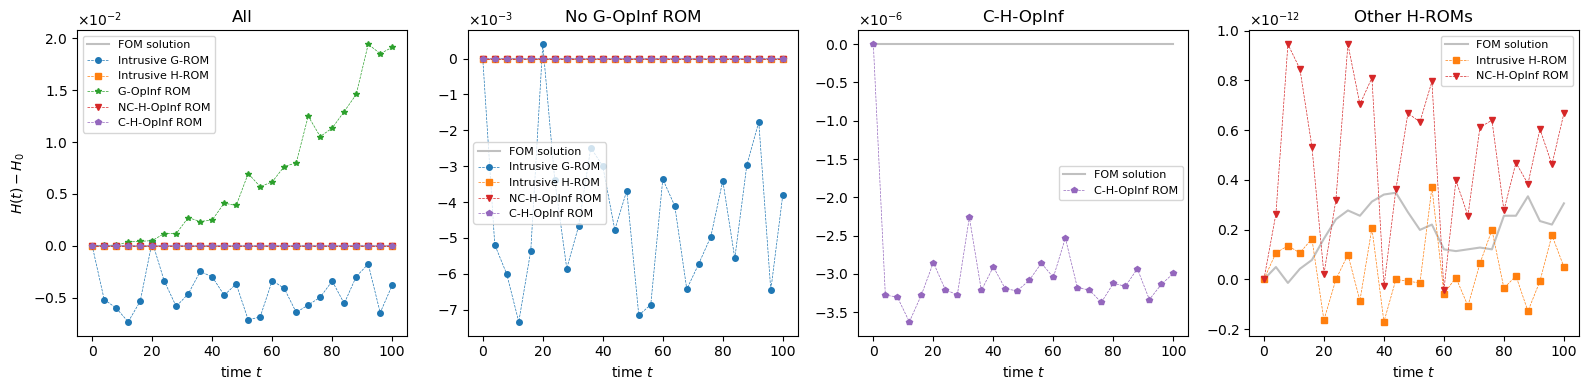

In [13]:
name = "tab10"
cmap = plt.get_cmap(name)

plt.rcParams['axes.formatter.useoffset'] = True 

fig, ax = plt.subplots(1, 4, figsize=(16,4), sharex=True)
ax.flatten()[0].set_ylabel(r'$H(t) - H_0$')

skip=20
i,j,k = 2,2,3

titleList   = ['All', 
               'No G-OpInf ROM',
               'C-H-OpInf' , 
               'Other H-ROMs']

ax.flatten()[0].plot(tTest[::skip], exactE[j][::skip]-exactE[j][0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[0].plot(tTest[::skip], HamileIntG[i,j,k][::skip]-HamileIntG[i,j,k][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileIntH[i,j,k][::skip]-HamileIntH[i,j,k][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOp[i,j,k][::skip]-HamileOp[i,j,k][0],  label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpH[i,j,k][::skip]-HamileOpH[i,j,k][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpA[i,j,k][::skip]-HamileOpA[i,j,k][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], exactE[j][::skip]-exactE[j][0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[1].plot(tTest[::skip], HamileIntG[i,j,k][::skip]-HamileIntG[i,j,k][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileIntH[i,j,k][::skip]-HamileIntH[i,j,k][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[1].plot(tTest[::skip], HamileOp[i,j,k][::skip]-HamileOp[i,j,k][0], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpH[i,j,k][::skip]-HamileOpH[i,j,k][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpA[i,j,k][::skip]-HamileOpA[i,j,k][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[2].plot(tTest[::skip], exactE[j][::skip]-exactE[j][::skip], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[2].plot(tTest[::skip], HamileOpA[i,j,k][::skip]-HamileOpA[i,j,k][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], exactE[j][::skip]-exactE[j][0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[3].plot(tTest[::skip], HamileIntH[i,j,k][::skip]-HamileIntH[i,j,k][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], HamileOpH[i,j,k][::skip]-HamileOpH[i,j,k][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[i].set_ylim([10**-5, 10**3.])
for i in range(4):
    ax.flatten()[i].set_title(f'{titleList[i]}', y=1.0)
    ax.flatten()[i].legend(prop={'size':8})
    ax.flatten()[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    ax.flatten()[i].set_xlabel('time $t$')
    # ax.flatten()[i].yaxis.set_major_formatter(y_formatter)
    # ax.flatten()[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2g'))
plt.tight_layout()
# plt.savefig(f'Energy{4*(k+1)}modesParametric', transparent=True)
plt.show()

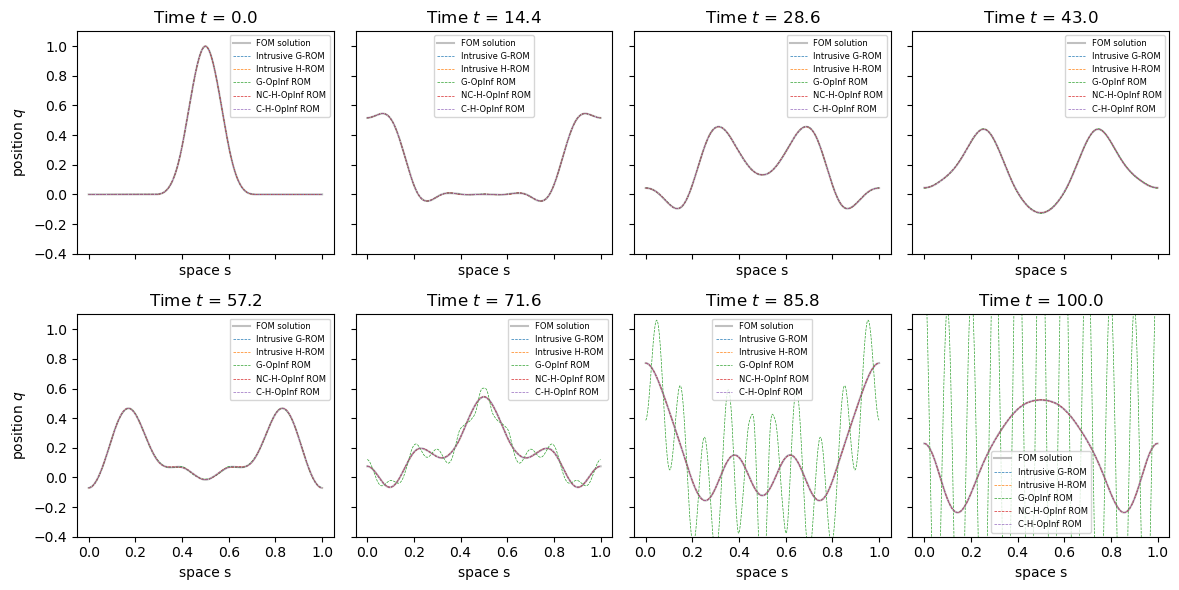

the times are [  0.   14.4  28.6  43.   57.2  71.6  85.8 100. ]


In [14]:
name = "tab10"
cmap = plt.get_cmap(name)

exactSol = Xac.transpose((1,0,2))

fig, ax = plt.subplots(2, 4, figsize=(12,6), sharex=True, sharey=True)

ax.flatten()[0].set_ylabel(f'position $q$')
ax.flatten()[4].set_ylabel(f'position $q$')
ax.flatten()[0].set_ylim([-0.4,1.1])

i,j,k = 0,2,6
tList = [0, 40, 65, 120, 180, 240, 400, 500]
tList = [int(np.ceil(500/7*i)) for i in range(8)]
for l,t in enumerate(tList):
    ax.flatten()[l].plot(xTrain, exactSol[j][:Nover2,t], label='FOM solution', color='silver', linestyle='-')
    ax.flatten()[l].plot(xTrain, XrecIntG[i,j,k][:Nover2,t], label='Intrusive G-ROM', color=cmap.colors[0], linestyle='--', linewidth=0.5, markersize=0.1)
    ax.flatten()[l].plot(xTrain, XrecIntH[i,j,k][:Nover2,t], label='Intrusive H-ROM', color=cmap.colors[1], linestyle='--', linewidth=0.5, markersize=0.1)
    ax.flatten()[l].plot(xTrain, XrecOp[i,j,k][:Nover2,t], label='G-OpInf ROM', color=cmap.colors[2], linestyle='--', linewidth=0.5, markersize=0.1)
    ax.flatten()[l].plot(xTrain, XrecOpH[i,j,k][:Nover2,t], label='NC-H-OpInf ROM', color=cmap.colors[3], linestyle='--', linewidth=0.5, markersize=0.1)
    ax.flatten()[l].plot(xTrain, XrecOpA[i,j,k][:Nover2,t], label='C-H-OpInf ROM', color=cmap.colors[4], linestyle='--', linewidth=0.5, markersize=0.1)
    # ax.flatten()[j].set_ylim([-0.4,7.5])
    ax.flatten()[l].set_title(f'Time $t$ = {t/5}')
    ax.flatten()[l].set_xlabel(f'space s')

    ax.flatten()[l].legend(prop={'size':6})
plt.tight_layout()
# plt.savefig(f'WaveSoln{4*(k+1)}ModesParametric', transparent=True)
plt.show()

print(f'the times are {tTest[tList]}')

arrs = np.array([exactSol[j][:Nover2], XrecIntG[i,j,k][:Nover2], XrecIntH[i,j,k][:Nover2],
                 XrecOp[i,j,k][:Nover2], XrecOpH[i,j,k][:Nover2], XrecOpA[i,j,k][:Nover2]])
styles = ['-', '--', '--', '--', '--', '--']
labels = ['1', '2', '3', '4', '5', '6']

# ru.animate_array(arrs, styles, labels, np.array(xTrain))

# print(Xac.shape, XrecOpA.shape)




# # exact = 0.1 * np.sum(Xac[:Nover2]*Xac[Nover2:], axis=0) * dx
# intG  = 0.1 * np.sum(XrecIntG[2,0,4][:Nover2]*XrecIntG[2,0,4][Nover2:], axis=0) * dx
# intH  = 0.1 * np.sum(XrecIntH[2,0,4][:Nover2]*XrecIntH[2,0,4][Nover2:], axis=0) * dx
# op  = 0.1 * np.sum(XrecOp[2,0,4][:Nover2]*XrecOp[2,0,4][Nover2:], axis=0) * dx
# opH  = 0.1 * np.sum(XrecOpH[2,0,4][:Nover2]*XrecOpH[2,0,4][Nover2:], axis=0) * dx
# opA  = 0.1 * np.sum(XrecOpA[2,0,4][:Nover2]*XrecOpA[2,0,4][Nover2:], axis=0) * dx
# # plt.plot(tTest, exact)
# plt.plot(tTest, intG)
# plt.plot(tTest, intH)
# plt.plot(tTest, op)
# plt.plot(tTest, opH)
# # plt.plot(tTest, opA)